In [17]:
# Análisis Exploratorio de Datos - Demanda Energética Cuba
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [18]:
# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10



In [ ]:
def load_and_prepare_data(file_path):
    """Carga y prepara los datos iniciales"""
    df = pd.read_csv(file_path)
    
    # Convertir fecha a datetime
    df['fecha'] = pd.to_datetime(df['fecha'])
    
    # Crear variables derivadas adicionales
    df['deficit_real'] = df['demanda_maxima'] - df['disponibilidad_total']
    df['margen_seguridad'] = df['disponibilidad_total'] - df['demanda_maxima']
    df['eficiencia_07am'] = df['disponibilidad_07am'] / df['disponibilidad_total'] * 100
    df['utilizacion_07am'] = df['demanda_07am'] / df['disponibilidad_07am'] * 100
    
    # Categorizar días
    df['tipo_dia'] = df['dia_semana'].map({
        0: 'Lunes', 1: 'Martes', 2: 'Miércoles', 3: 'Jueves',
        4: 'Viernes', 5: 'Sábado', 6: 'Domingo'
    })
    
    return df


file_path = 'data/processed/cleaned_energy_data.csv'
df = load_and_prepare_data(file_path)

In [20]:
# =============================================
# 2. ANÁLISIS DESCRIPTIVO BÁSICO
# =============================================

def analisis_descriptivo_basico(df):
    """Análisis descriptivo completo"""
    print("="*60)
    print("📊 ANÁLISIS DESCRIPTIVO BÁSICO")
    print("="*60)
    
    # Información general
    print(f"📅 Período: {df['fecha'].min()} a {df['fecha'].max()}")
    print(f"📈 Total de observaciones: {len(df)}")
    print(f"🗓️ Días únicos: {df['fecha'].dt.date.nunique()}")
    
    # Estadísticas descriptivas de variables clave
    variables_clave = ['demanda_maxima', 'disponibilidad_total', 'deficit_predicho', 
                      'afectacion_predicha', 'plantas_averiadas', 'plantas_mantenimiento']
    
    print("\n📋 ESTADÍSTICAS DESCRIPTIVAS - Variables Energéticas:")
    print(df[variables_clave].describe().round(2))
    
    # Valores faltantes
    print("\n❓ VALORES FALTANTES:")
    missing_data = df.isnull().sum()
    missing_percent = (missing_data / len(df)) * 100
    missing_df = pd.DataFrame({
        'Valores Faltantes': missing_data,
        'Porcentaje': missing_percent.round(2)
    })
    print(missing_df[missing_df['Valores Faltantes'] > 0])

analisis_descriptivo_basico(df)

📊 ANÁLISIS DESCRIPTIVO BÁSICO
📅 Período: 2022-12-02 10:34:00 a 2025-05-09 08:27:00
📈 Total de observaciones: 696
🗓️ Días únicos: 689

📋 ESTADÍSTICAS DESCRIPTIVAS - Variables Energéticas:
       demanda_maxima  disponibilidad_total  deficit_predicho  \
count          692.00                693.00            641.00   
mean          2986.58               2292.08            744.15   
std            229.26                357.80            496.30   
min           2450.00               1460.00              2.00   
25%           2800.00               1980.00            305.00   
50%           3000.00               2326.00            661.00   
75%           3162.50               2583.00           1208.00   
max           3500.00               3109.00           1800.00   

       afectacion_predicha  plantas_averiadas  plantas_mantenimiento  
count               675.00             696.00                 696.00  
mean                791.23               2.84                   2.53  
std           


📈 ANÁLISIS DE PATRONES TEMPORALES


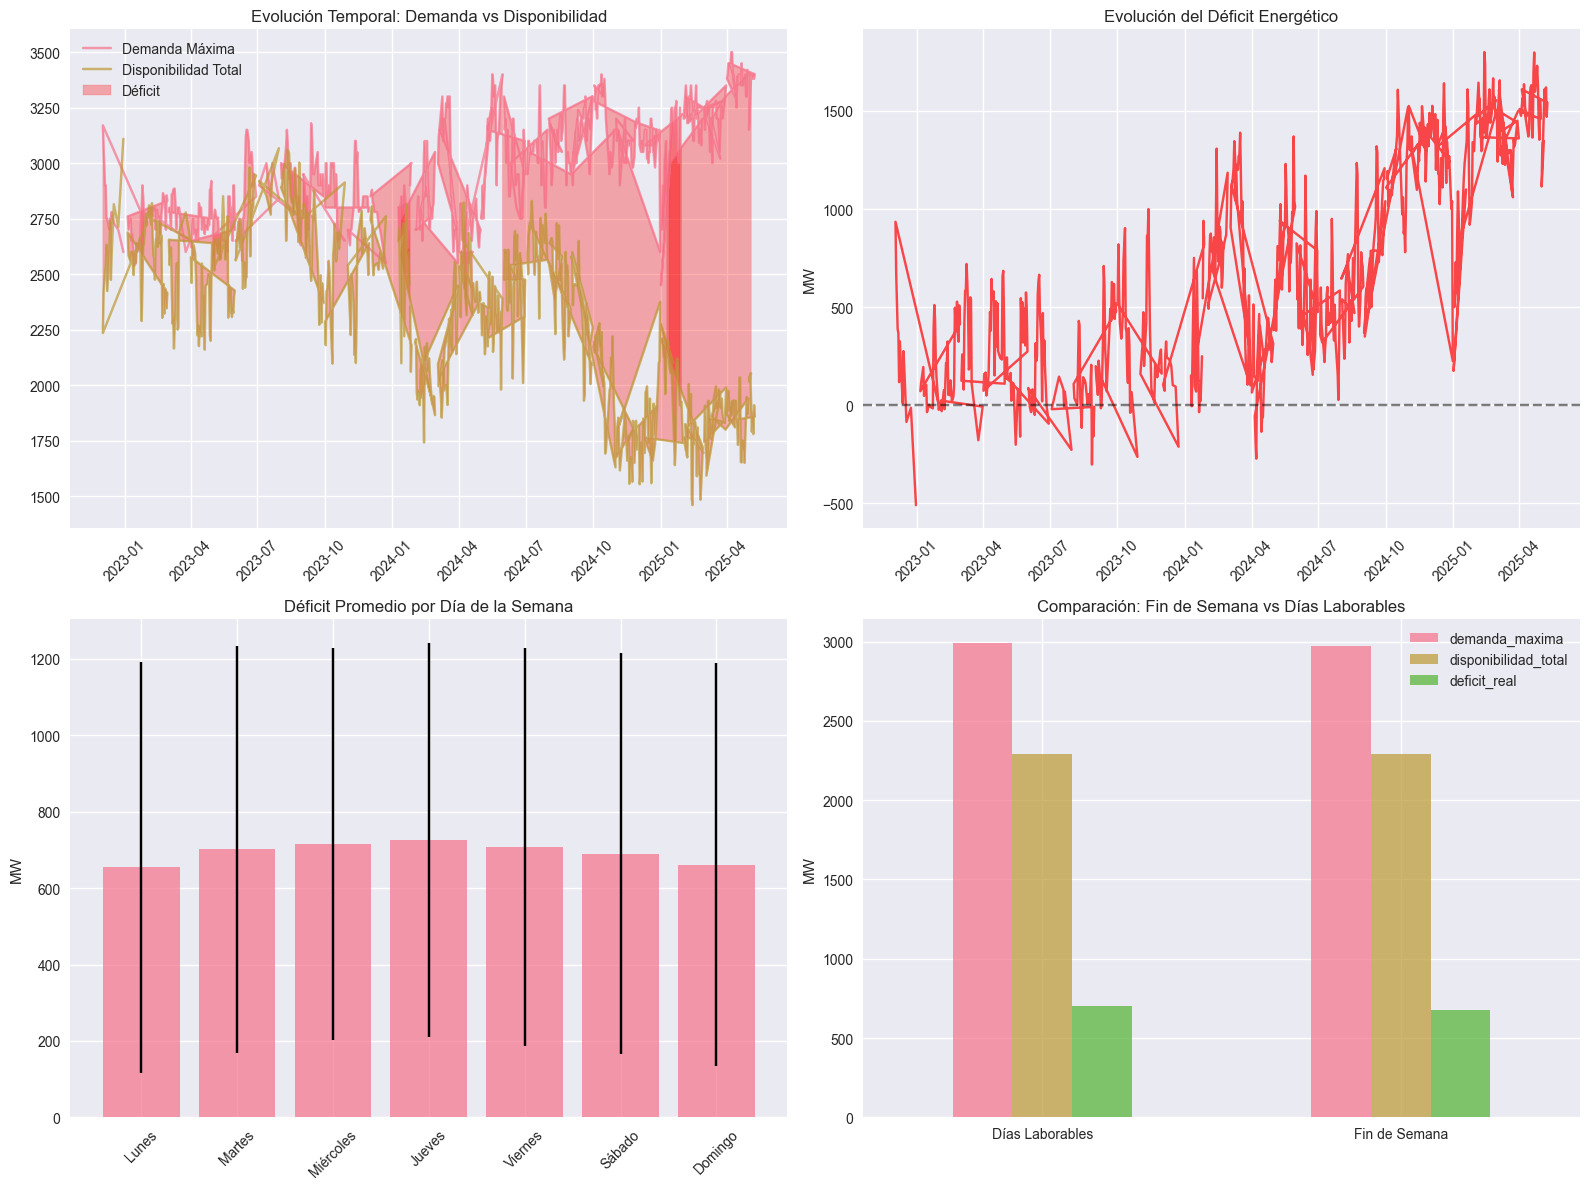

In [21]:

# =============================================
# 3. ANÁLISIS TEMPORAL
# =============================================

def analisis_temporal(df):
    """Análisis de patrones temporales"""
    print("\n" + "="*60)
    print("📈 ANÁLISIS DE PATRONES TEMPORALES")
    print("="*60)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Serie temporal de demanda vs disponibilidad
    axes[0,0].plot(df['fecha'], df['demanda_maxima'], label='Demanda Máxima', alpha=0.7)
    axes[0,0].plot(df['fecha'], df['disponibilidad_total'], label='Disponibilidad Total', alpha=0.7)
    axes[0,0].fill_between(df['fecha'], df['demanda_maxima'], df['disponibilidad_total'], 
                          where=(df['disponibilidad_total'] < df['demanda_maxima']), 
                          color='red', alpha=0.3, label='Déficit')
    axes[0,0].set_title('Evolución Temporal: Demanda vs Disponibilidad')
    axes[0,0].legend()
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # Déficit a lo largo del tiempo
    axes[0,1].plot(df['fecha'], df['deficit_real'], color='red', alpha=0.7)
    axes[0,1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[0,1].set_title('Evolución del Déficit Energético')
    axes[0,1].set_ylabel('MW')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # Patrones por día de la semana
    deficit_por_dia = df.groupby('tipo_dia')['deficit_real'].agg(['mean', 'std']).reset_index()
    orden_dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
    deficit_por_dia['tipo_dia'] = pd.Categorical(deficit_por_dia['tipo_dia'], categories=orden_dias, ordered=True)
    deficit_por_dia = deficit_por_dia.sort_values('tipo_dia')
    
    axes[1,0].bar(deficit_por_dia['tipo_dia'], deficit_por_dia['mean'], 
                 yerr=deficit_por_dia['std'], capsize=5, alpha=0.7)
    axes[1,0].set_title('Déficit Promedio por Día de la Semana')
    axes[1,0].set_ylabel('MW')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # Fin de semana vs días laborables
    fin_semana_stats = df.groupby('es_fin_semana')[['demanda_maxima', 'disponibilidad_total', 'deficit_real']].mean()
    fin_semana_stats.index = ['Días Laborables', 'Fin de Semana']
    fin_semana_stats.plot(kind='bar', ax=axes[1,1], alpha=0.7)
    axes[1,1].set_title('Comparación: Fin de Semana vs Días Laborables')
    axes[1,1].set_ylabel('MW')
    axes[1,1].legend()
    axes[1,1].tick_params(axis='x', rotation=0)
    
    plt.tight_layout()
    plt.show()

analisis_temporal(df)


🔗 ANÁLISIS DE CORRELACIONES


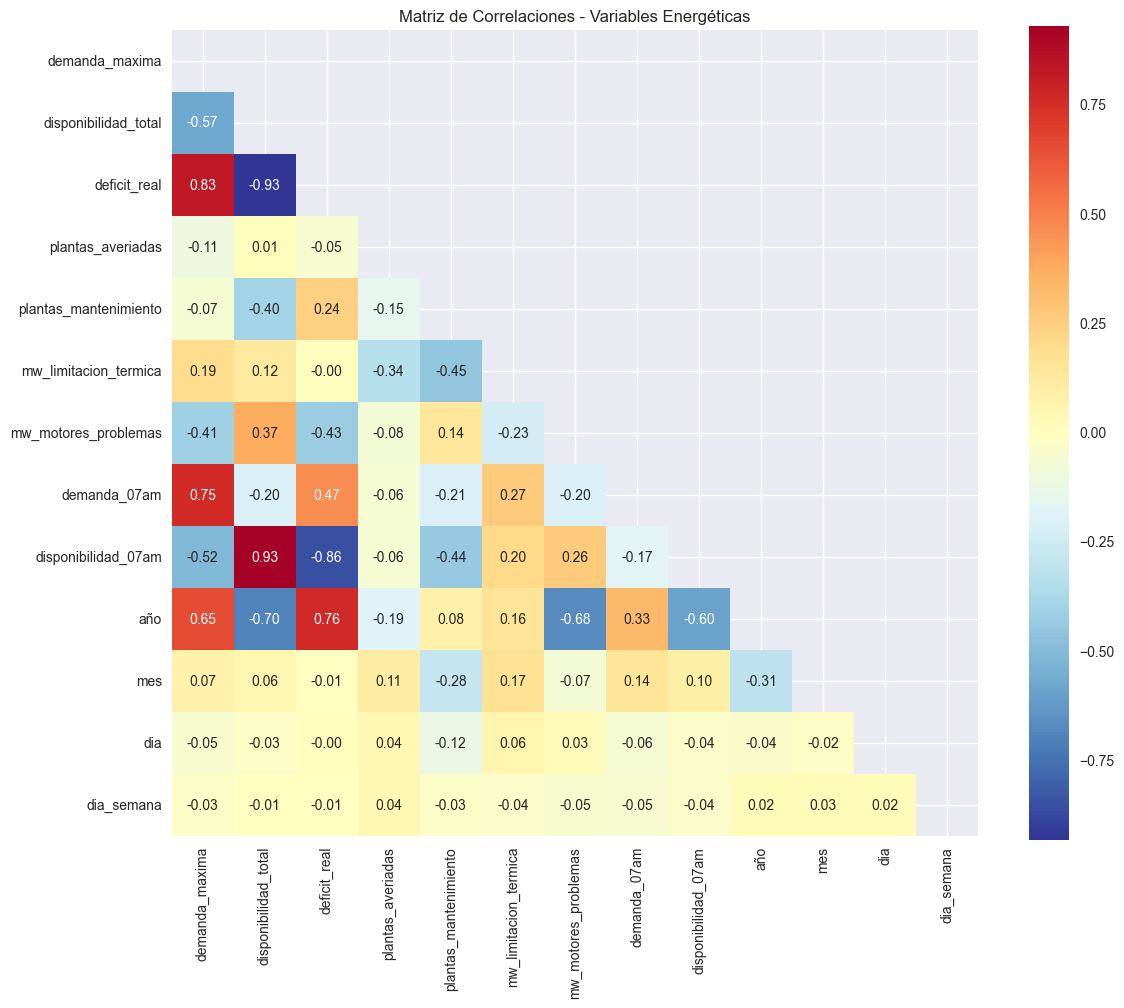


🎯 CORRELACIONES MÁS FUERTES CON LA DEMANDA MAXIMA:
  deficit_real: 0.828
  demanda_07am: 0.755
  año: 0.655
  disponibilidad_total: -0.573
  disponibilidad_07am: -0.518
  mw_motores_problemas: -0.410
  mw_limitacion_termica: 0.192
  plantas_averiadas: -0.108
  mes: 0.073
  plantas_mantenimiento: -0.066
  dia: -0.050
  dia_semana: -0.032

🎯 CORRELACIONES MÁS FUERTES CON Deficit:
  disponibilidad_total: -0.934
  disponibilidad_07am: -0.861
  demanda_maxima: 0.828
  año: 0.761
  demanda_07am: 0.466
  mw_motores_problemas: -0.432
  plantas_mantenimiento: 0.243
  plantas_averiadas: -0.054
  dia_semana: -0.008
  mes: -0.006
  dia: -0.001
  mw_limitacion_termica: -0.001

🎯 CORRELACIONES MÁS FUERTES CON Disponibilidad:
  deficit_real: -0.934
  disponibilidad_07am: 0.929
  año: -0.696
  demanda_maxima: -0.573
  plantas_mantenimiento: -0.397
  mw_motores_problemas: 0.370
  demanda_07am: -0.201
  mw_limitacion_termica: 0.124
  mes: 0.055
  dia: -0.030
  plantas_averiadas: 0.010
  dia_semana: -0.

In [26]:
# =============================================
# 4. ANÁLISIS DE CORRELACIONES
# =============================================

def analisis_correlaciones(df):
    """Matriz de correlaciones y análisis de relaciones"""
    print("\n" + "="*60)
    print("🔗 ANÁLISIS DE CORRELACIONES")
    print("="*60)
    
    # Seleccionar variables numéricas relevantes
    vars_numericas = ['demanda_maxima', 'disponibilidad_total', 'deficit_real', 
                     'plantas_averiadas', 'plantas_mantenimiento', 'mw_limitacion_termica',
                     'mw_motores_problemas', 'demanda_07am', 'disponibilidad_07am','año','mes','dia','dia_semana']
    
    # Filtrar solo variables que existen y tienen datos
    vars_disponibles = [var for var in vars_numericas if var in df.columns]
    df_corr = df[vars_disponibles].dropna()
    
    # Matriz de correlación
    correlation_matrix = df_corr.corr()
    
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdYlBu_r', 
                center=0, square=True, fmt='.2f')
    plt.title('Matriz de Correlaciones - Variables Energéticas')
    plt.tight_layout()
    plt.show()
    
    # Top correlaciones con demanda
    if 'demanda_maxima' in correlation_matrix.columns:
        deficit_corr = correlation_matrix['demanda_maxima'].drop('demanda_maxima').sort_values(key=abs, ascending=False)
        print("\n🎯 CORRELACIONES MÁS FUERTES CON LA DEMANDA MAXIMA:")
        for var, corr in deficit_corr.head(13).items():
            print(f"  {var}: {corr:.3f}")

    # Top correlaciones con déficit
    if 'deficit_real' in correlation_matrix.columns:
        deficit_corr = correlation_matrix['deficit_real'].drop('deficit_real').sort_values(key=abs, ascending=False)
        print("\n🎯 CORRELACIONES MÁS FUERTES CON Deficit:")
        for var, corr in deficit_corr.head(13).items():
            print(f"  {var}: {corr:.3f}")

    # Top correlaciones con disponibilidad
    if 'disponibilidad_total' in correlation_matrix.columns:
        deficit_corr = correlation_matrix['disponibilidad_total'].drop('disponibilidad_total').sort_values(key=abs, ascending=False)
        print("\n🎯 CORRELACIONES MÁS FUERTES CON Disponibilidad:")
        for var, corr in deficit_corr.head(13).items():
            print(f"  {var}: {corr:.3f}")
analisis_correlaciones(df)


⚡ ANÁLISIS DE PLANTAS Y AVERÍAS


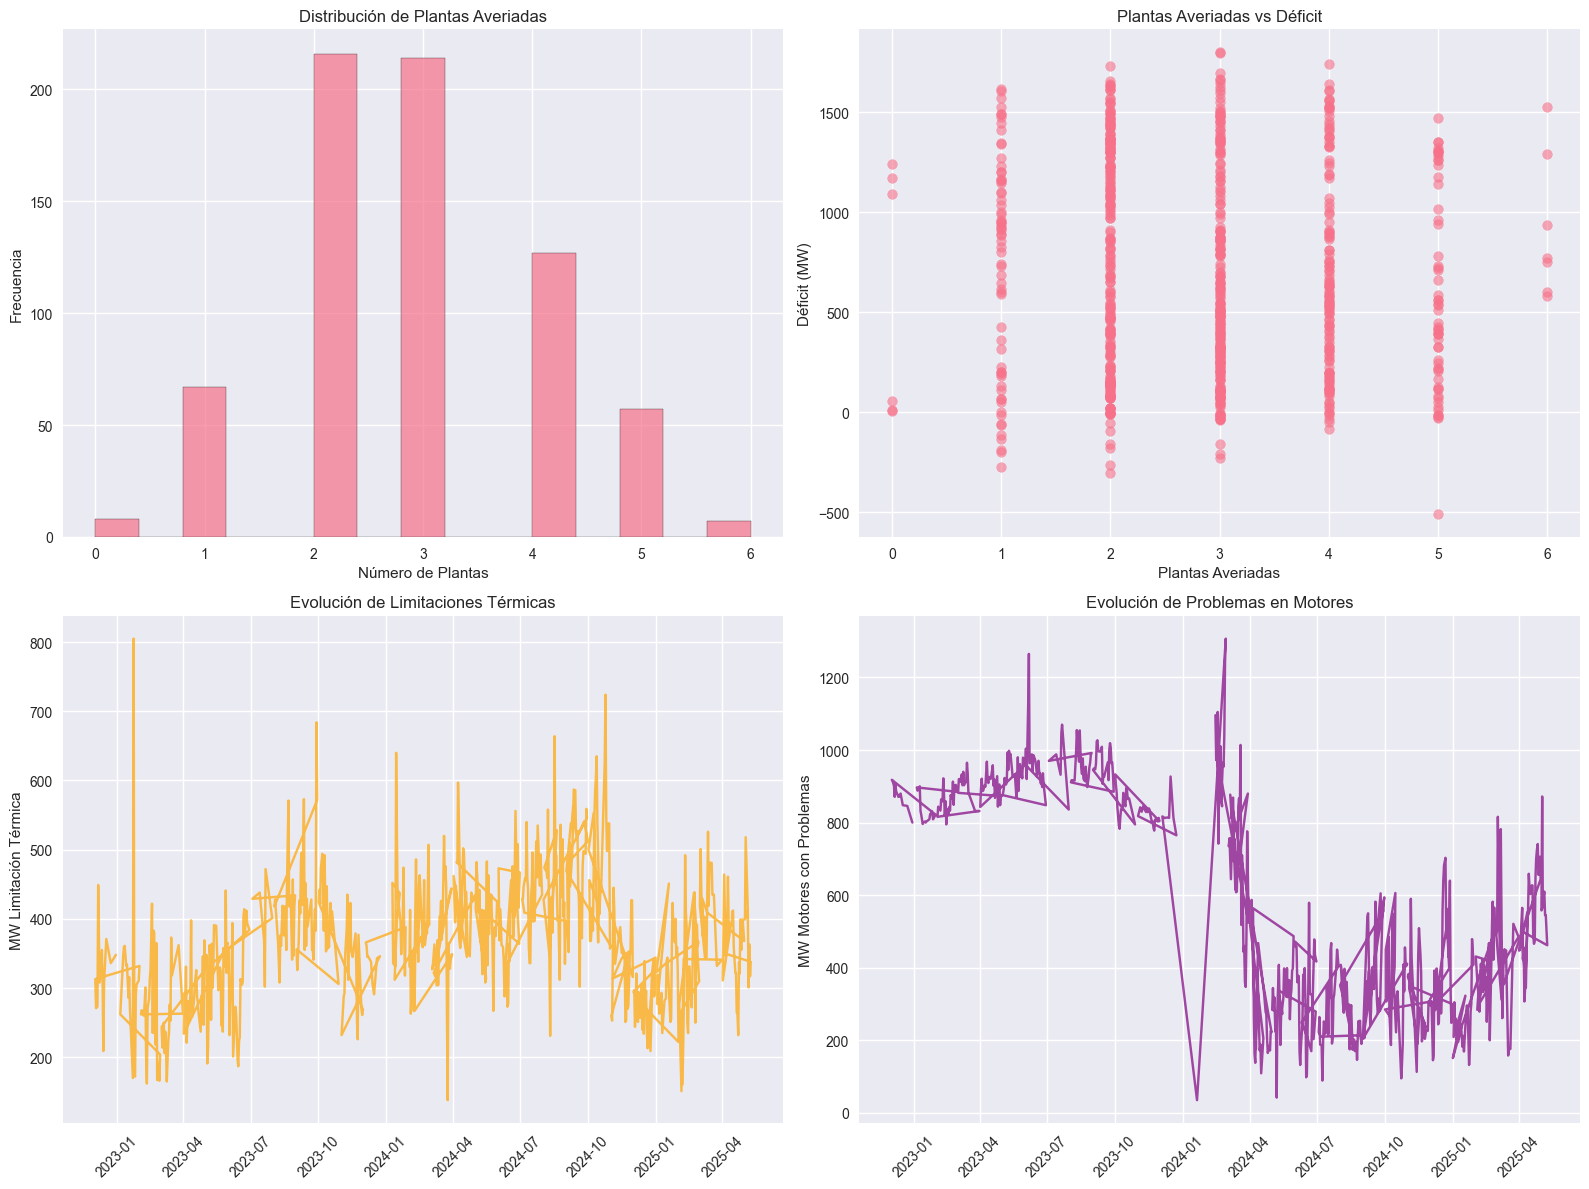

🔧 Promedio de plantas averiadas: 2.8
🛠️ Promedio de plantas en mantenimiento: 2.5
🌡️ Promedio de limitación térmica: 369.2 MW


In [23]:
# =============================================
# 5. ANÁLISIS DE PLANTAS Y AVERÍAS
# =============================================

def analisis_plantas_averias(df):
    """Análisis específico de plantas y averías"""
    print("\n" + "="*60)
    print("⚡ ANÁLISIS DE PLANTAS Y AVERÍAS")
    print("="*60)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Distribución de plantas averiadas
    axes[0,0].hist(df['plantas_averiadas'].dropna(), bins=15, alpha=0.7, edgecolor='black')
    axes[0,0].set_title('Distribución de Plantas Averiadas')
    axes[0,0].set_xlabel('Número de Plantas')
    axes[0,0].set_ylabel('Frecuencia')
    
    # Plantas averiadas vs déficit
    df_clean = df.dropna(subset=['plantas_averiadas', 'deficit_real'])
    axes[0,1].scatter(df_clean['plantas_averiadas'], df_clean['deficit_real'], alpha=0.6)
    axes[0,1].set_title('Plantas Averiadas vs Déficit')
    axes[0,1].set_xlabel('Plantas Averiadas')
    axes[0,1].set_ylabel('Déficit (MW)')
    
    # Evolución de limitaciones térmicas
    if 'mw_limitacion_termica' in df.columns:
        df_temp = df.dropna(subset=['mw_limitacion_termica'])
        axes[1,0].plot(df_temp['fecha'], df_temp['mw_limitacion_termica'], alpha=0.7, color='orange')
        axes[1,0].set_title('Evolución de Limitaciones Térmicas')
        axes[1,0].set_ylabel('MW Limitación Térmica')
        axes[1,0].tick_params(axis='x', rotation=45)
    
    # Problemas de motores
    if 'mw_motores_problemas' in df.columns:
        df_motores = df.dropna(subset=['mw_motores_problemas'])
        axes[1,1].plot(df_motores['fecha'], df_motores['mw_motores_problemas'], alpha=0.7, color='purple')
        axes[1,1].set_title('Evolución de Problemas en Motores')
        axes[1,1].set_ylabel('MW Motores con Problemas')
        axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Estadísticas de plantas
    print(f"🔧 Promedio de plantas averiadas: {df['plantas_averiadas'].mean():.1f}")
    print(f"🛠️ Promedio de plantas en mantenimiento: {df['plantas_mantenimiento'].mean():.1f}")
    print(f"🌡️ Promedio de limitación térmica: {df['mw_limitacion_termica'].mean():.1f} MW")

analisis_plantas_averias(df)


⚠️ ANÁLISIS DE DÉFICIT Y AFECTACIONES
📊 DISTRIBUCIÓN DE SEVERIDAD DEL DÉFICIT:
  Déficit Severo: 490 días (70.4%)
  Déficit Moderado: 109 días (15.7%)
  Equilibrio: 50 días (7.2%)
  Exceso Bajo: 30 días (4.3%)
  Exceso Alto: 13 días (1.9%)


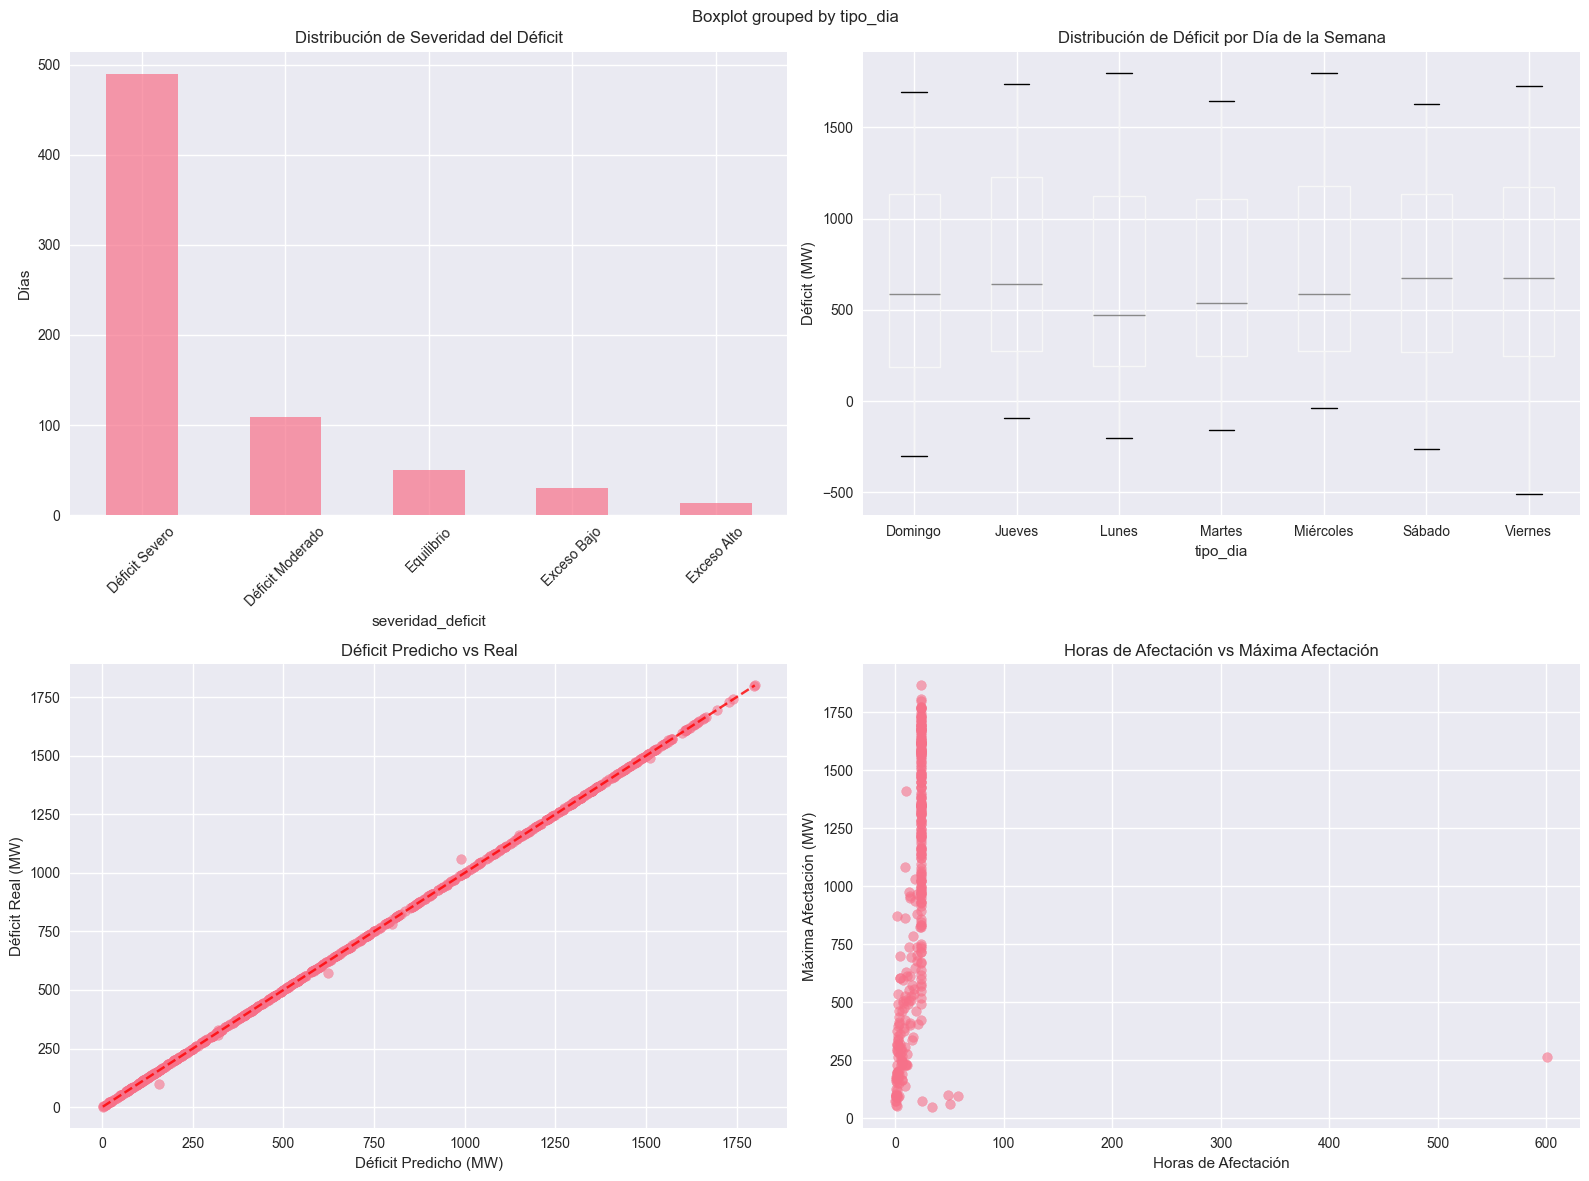

In [24]:
# =============================================
# 6. ANÁLISIS DE DÉFICIT Y AFECTACIONES
# =============================================

def analisis_deficit_afectaciones(df):
    """Análisis específico de déficit y afectaciones"""
    print("\n" + "="*60)
    print("⚠️ ANÁLISIS DE DÉFICIT Y AFECTACIONES")
    print("="*60)
    
    # Categorizar severidad del déficit
    df['severidad_deficit'] = pd.cut(df['deficit_real'], 
                                   bins=[-np.inf, -100, 0, 100, 300, np.inf],
                                   labels=['Exceso Alto', 'Exceso Bajo', 'Equilibrio', 'Déficit Moderado', 'Déficit Severo'])
    
    # Distribución de severidad
    severidad_counts = df['severidad_deficit'].value_counts()
    print("📊 DISTRIBUCIÓN DE SEVERIDAD DEL DÉFICIT:")
    for categoria, count in severidad_counts.items():
        porcentaje = (count / len(df)) * 100
        print(f"  {categoria}: {count} días ({porcentaje:.1f}%)")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Gráfico de severidad
    severidad_counts.plot(kind='bar', ax=axes[0,0], alpha=0.7)
    axes[0,0].set_title('Distribución de Severidad del Déficit')
    axes[0,0].set_ylabel('Días')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # Boxplot de déficit por día de semana
    df.boxplot(column='deficit_real', by='tipo_dia', ax=axes[0,1])
    axes[0,1].set_title('Distribución de Déficit por Día de la Semana')
    axes[0,1].set_ylabel('Déficit (MW)')
    
    # Predicho vs Real (si disponible)
    if 'deficit_predicho' in df.columns and 'afectacion_predicha' in df.columns:
        df_pred = df.dropna(subset=['deficit_predicho', 'deficit_real'])
        if len(df_pred) > 0:
            axes[1,0].scatter(df_pred['deficit_predicho'], df_pred['deficit_real'], alpha=0.6)
            axes[1,0].plot([df_pred['deficit_predicho'].min(), df_pred['deficit_predicho'].max()], 
                          [df_pred['deficit_predicho'].min(), df_pred['deficit_predicho'].max()], 
                          'r--', alpha=0.8)
            axes[1,0].set_title('Déficit Predicho vs Real')
            axes[1,0].set_xlabel('Déficit Predicho (MW)')
            axes[1,0].set_ylabel('Déficit Real (MW)')
    
    # Horas de afectación vs Max afectación
    if 'horas_afectacion' in df.columns and 'max_afectacion_mw' in df.columns:
        df_afect = df.dropna(subset=['horas_afectacion', 'max_afectacion_mw'])
        if len(df_afect) > 0:
            axes[1,1].scatter(df_afect['horas_afectacion'], df_afect['max_afectacion_mw'], alpha=0.6)
            axes[1,1].set_title('Horas de Afectación vs Máxima Afectación')
            axes[1,1].set_xlabel('Horas de Afectación')
            axes[1,1].set_ylabel('Máxima Afectación (MW)')
    
    plt.tight_layout()
    plt.show()

analisis_deficit_afectaciones(df)


🔍 DETECCIÓN DE VALORES ATÍPICOS

📊 demanda_maxima:
  Outliers detectados: 0
  Rango normal: [2256.2, 3706.2]

📊 disponibilidad_total:
  Outliers detectados: 0
  Rango normal: [1075.5, 3487.5]

📊 deficit_real:
  Outliers detectados: 0
  Rango normal: [-1196.0, 2598.0]


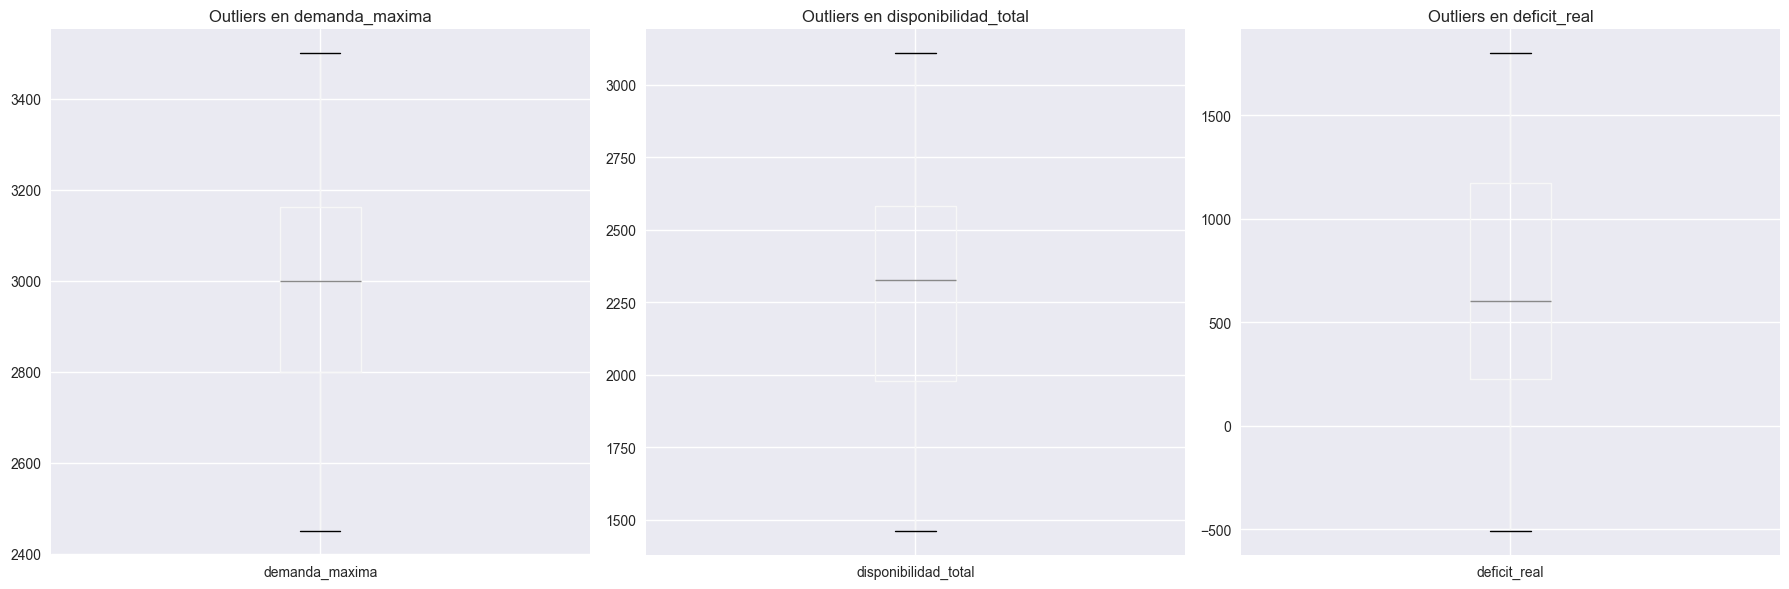

In [25]:
# =============================================
# 7. DETECCIÓN DE OUTLIERS
# =============================================

def deteccion_outliers(df):
    """Detección y visualización de valores atípicos"""
    print("\n" + "="*60)
    print("🔍 DETECCIÓN DE VALORES ATÍPICOS")
    print("="*60)
    
    variables_analizar = ['demanda_maxima', 'disponibilidad_total', 'deficit_real']
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for i, var in enumerate(variables_analizar):
        if var in df.columns:
            # Boxplot
            df.boxplot(column=var, ax=axes[i])
            axes[i].set_title(f'Outliers en {var}')
            
            # Calcular outliers usando IQR
            Q1 = df[var].quantile(0.25)
            Q3 = df[var].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outliers = df[(df[var] < lower_bound) | (df[var] > upper_bound)]
            print(f"\n📊 {var}:")
            print(f"  Outliers detectados: {len(outliers)}")
            print(f"  Rango normal: [{lower_bound:.1f}, {upper_bound:.1f}]")
            
            if len(outliers) > 0:
                print("  Fechas con outliers:")
                for fecha in outliers['fecha'].head(5):
                    print(f"    - {fecha}")
    
    plt.tight_layout()
    plt.show()

deteccion_outliers(df)